<a href="https://colab.research.google.com/github/pmilks/cap-comp215/blob/main/Project%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Database Creation

In [124]:
import json, requests, os, pprint
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

client_id = 'lsNiv49bimpMq7ObIMsu34JI'
client_secret = 'lRt51ghfyTpL4lAQ5Xwr9o8QMI4RMM4aUeIlJ3Guz7OFBGtV'

class Photo:
  def __init__(self, id, keywords):
    self.id = id
    self.keywords = keywords

  def __str__(self):
    return f"{self.id}: {self.keywords}"

  @classmethod
  def Categorize(cls, id):
    with open(id,'rb') as image:
      data = {'data': image}
      keywords = requests.post('https://api.everypixel.com/v1/keywords', files=data,
                               auth=(client_id, client_secret)).json()['keywords']
      categories = {entry['keyword']:entry['score'] for entry in keywords[:10]}
    return Photo(categories=categories, id=id)
  
  def content_filter(self, *args):
    if set(self.keywords.keys()) & set(args):
      return True #Flagged content
    else:
      return False #Not flagged content

  def match_keywords(self, other):
    matching_kw = set(self.keywords.keys()) & set(other.keywords.keys())
    if not matching_kw:
      return
    return {match_kw:1-abs(self.keywords[match_kw]-other.keywords[match_kw]) for match_kw in matching_kw}
  
  def sort_most_matches(matches):
    return sorted([(k, len(matches[k])) for k in matches.keys()], key=lambda x:x[1], reverse=True)

  def similarity_score(self, other):
    #similarity of SELF TO OTHER
    comp = self.match_keywords(other)
    score = 0
    for kw in comp.keys():
      score += self.keywords[kw]*comp[kw]
    return score/len(self.keywords)
    #perfect match = 1
    #no match = 0

with open('bank.txt','r') as f:
  database = json.loads(f.read())
  database = [Photo(id=photo, keywords=database[photo]) for photo in database.keys()]

In [129]:
army = Photo(id="army.jpg", keywords={"army": 0.9942000531810699, "armed forces": 0.9858088343087792, "military": 0.9851124039444504, "uniform": 0.9554957802768743, "war": 0.9282700337748006, "weapon": 0.8754790228124641, "rifle": 0.8405221248697905, "special forces": 0.6011035062726361, "outdoors": 0.5882105259291452, "men": 0.502345745936619, "camouflage clothing": 0.4691646829093634, "gun": 0.44768096851025635, "conflict": 0.44314516737482995, "work helmet": 0.4387717699150603, "parade": 0.3805579027471689})
firefighter = Photo(id="firefighter.jpg", keywords={"firefighter": 0.990223655793471, "fire": 0.9889083740936826, "natural phenomenon": 0.9889083740936826, "flame": 0.9862995986658112, "occupation": 0.9299696275540256, "heat": 0.9158851761381906, "temperature": 0.9158851761381906, "burning": 0.9092153643651081, "working": 0.8834813242714334, "men": 0.7701041699748132, "work helmet": 0.703411281697038, "protective suit": 0.6753508082578237, "rescue": 0.6736560285389862, "hardhat": 0.5607262192933496, "fire hose": 0.5259593673260592})

new_photo = army

all_matches = {data.id:new_photo.match_keywords(data) for data in database if new_photo.match_keywords(data)}
all_matches_scored = [(data.id,army.similarity_score(data)) for data in database if army.match_keywords(data)]
sorted(all_matches_scored,key=lambda x:x[1],reverse=True)

[('army.jpg', 0.6957245681842206),
 ('policeman.jpg', 0.10638693205228657),
 ('baseball.jpg', 0.06817459501384837),
 ('construction.jpg', 0.06542872194851562),
 ('football.jpeg', 0.06043971075228517),
 ('tennis.jpg', 0.05338793186544654),
 ('gardening.jpg', 0.05233953888107313),
 ('firefighter.jpg', 0.04603292424155755),
 ('minivan.jpg', 0.038626154446830506),
 ('boat.jpg', 0.03857783507638016),
 ('nyc.jpg', 0.03768152853064808),
 ('machupichu.jpg', 0.03726988691416808),
 ('colleseum.jpg', 0.03593097781606237),
 ('petra.jpg', 0.03536127623898731),
 ('tajmahal.jpg', 0.034847492645274536),
 ('golf.jpg', 0.033110061165336956),
 ('train.jpg', 0.03266038774301119),
 ('camel.png', 0.03217970607416475),
 ('wallofchina.jpg', 0.03143030142187125),
 ('gorilla.jpg', 0.031100397009360535),
 ('parrot.jpg', 0.030159462418223804),
 ('christ.jpg', 0.02934359061576895),
 ('basketball.jpg', 0.028256749059726912),
 ('swimming.jpg', 0.02628208078665277),
 ('hockey.jpg', 0.025858903045388435),
 ('edsheeran

In [128]:
class Profile:
  def __init__(self, interests):
    self.interests = interests

  def __str__(self):
    return f"Interests:{self.interests}"

  def engagement(self, photo):
    for kw in photo.keywords.keys():
      if kw not in self.interests.keys():
        self.interests[kw] = 0.1*photo.keywords[kw]
      else:
        self.interests[kw] += (1-self.interests[kw])*(0.5**(1-photo.keywords[kw]))

  def no_engagement(self,photo):
    for kw in photo.keywords.keys():
      if kw in self.interests.keys():
        self.interests[kw] -= 0.005
      if self.interests[kw] <= 0:
        del self.interests[kw]

  def accuracy(self,photo):
    score = 0
    for kw in set(self.interests.keys()) & set(photo.keywords.keys()):
      score += self.interests[kw]*photo.keywords[kw]
    return score/len(self.interests.keys())

user = Profile({"army": 0.05, "armed forces": 0.05, "military": 0.05, "uniform": 0.05, "war": 0.05, "weapon": 0.05, "rifle": 0.05, "special forces": 0.05, "outdoors": 0.05, "men": 0.05, "camouflage clothing": 0.05, "gun": 0.05, "conflict": 0.05, "work helmet": 0.05, "parade": 0.05})
accuracies = [(data.id, user.accuracy(data)) for data in database if user.accuracy(data) != 0]
sorted(accuracies, key=lambda x:x[1], reverse=True)

def Scroll(profile, photo):
  while True:
    

[('army.jpg', 0.034786228409211035),
 ('construction.jpg', 0.00864916904138203),
 ('policeman.jpg', 0.00828183544520456),
 ('tennis.jpg', 0.005504332006904765),
 ('gardening.jpg', 0.005456881914321486),
 ('firefighter.jpg', 0.004911718172239505),
 ('baseball.jpg', 0.004079468635883957),
 ('horse.jpg', 0.003318663386500133),
 ('doctor.jpg', 0.003317191935892134),
 ('boxing.jpg', 0.003312386217589618),
 ('cat.jpg', 0.003308696602050205),
 ('weightlifting.jpg', 0.003296793621637813),
 ('dog.jpg', 0.0032378076019077937),
 ('biking.jpg', 0.00315611329679799),
 ('soccer.jpg', 0.003092057580581477),
 ('theater.jpg', 0.0030094631956028117),
 ('parrot.jpg', 0.002730372835522656),
 ('motorcycle.jpg', 0.0026566824288933215),
 ('camel.png', 0.00255864489400463),
 ('football.jpeg', 0.002535029193700881),
 ('train.jpg', 0.0025177852317189923),
 ('golf.jpg', 0.0024795613813709),
 ('edsheeran.jpg', 0.002452541976163291),
 ('hockey.jpg', 0.0024340038820108542),
 ('swimming.jpg', 0.0023918837143088933),

Step 1. User uploads photo

Step 2. ML, NLP, Metadata tagging

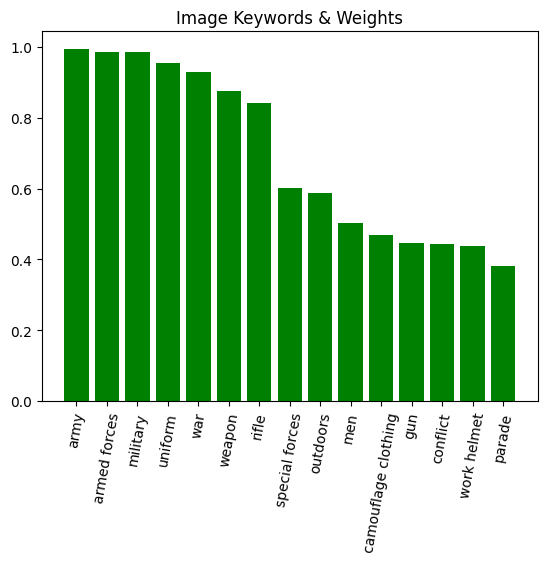

In [130]:
filephoto = ''
#new_upload = Photo.Categorize(filephoto)
new_upload = army
plt.bar(new_upload.keywords.keys(), new_upload.keywords.values(), color='g')
plt.title("Image Keywords & Weights")
plt.xticks(rotation=80)
plt.show()

Step 3. Content Flagging

In [131]:
if new_upload.content_filter('war'): #Replace hazard_tags
  print("Hazardous content: Rejected")
else:
  print("Suitable content: Accepted")

Hazardous content: Rejected


Step 4. Duplicate flagging

> *Introduced to "For You" page*

